# Sample Based Interior/Edge Segmentation for 3D Data

---

Classifies each pixel as either Cell Edge, Cell Interior, or Background.

There are 2 different Cell Edge classes (Cell-Cell Boundary and Cell-Background Boundary)

In [0]:
# !git clone https://github.com/vanvalenlab/deepcell-tf.git
#cd deepcell-tf
# docker build --build-arg TF_VERSION=1.15.0-gpu -t $USER/deepcell-tf .
# import os
# os.chdir('/content/deepcell-tf')
# !pip3 install -r requirements.txt
# !python3 setup.py install
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/deepcell-tf')
!ls
!python setup.py build_ext --inplace
!pip install -r requirements.txt

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
build		    deepcell	LICENSE     requirements-test.txt  setup.py
CODE_OF_CONDUCT.md  Dockerfile	pytest.ini  requirements.txt
CONTRIBUTING.md     docs	README.md   scripts
running build_ext
skipping 'deepcell/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.6/deepcell/utils/compute_overlap.cpython-36m-x86_64-linux-gnu.so -> deepcell/utils
     |████████████████████████████████| 10.4MB 5.3MB/s 
     |█████████████████████████

In [0]:
import os
import errno

import numpy as np

import deepcell
# comment the line from deepcell.utils.compute_overlap import compute_overlap in deepcell/metrics.py

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Load the Training Data

In [0]:
from deepcell import datasets
# Download the data (saves to ~/.keras/datasets)
filename = 'mousebrain.npz'
test_size = 0.1 # % of data saved as test
seed = 0 # seed for random train-test split

(X_train, y_train), (X_test, y_test) = deepcell.datasets.mousebrain.load_data(filename, test_size=test_size, seed=seed)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

1730158592/1730150850 [==============================] - 85s 0us/step
X.shape: (198, 15, 256, 256, 1)
y.shape: (198, 15, 256, 256, 1)


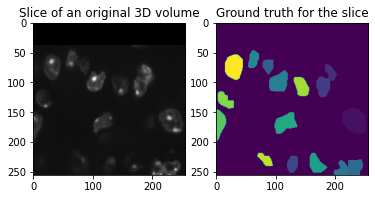

In [0]:
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1,2,1)
plt.imshow(X_train[40,11,:,:,0], cmap='gray')
plt.title('Slice of an original 3D volume')
plt.subplot(1,2,2)
plt.imshow(y_train[40,11,:,:,0])
plt.title('Ground truth for the slice')
plt.show()


### Set up filepath constants

In [0]:
# the path to the data file is currently required for `train_model_()` functions

# change DATA_DIR if you are not using `deepcell.datasets`
# DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))
DATA_DIR = '/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/'
# DATA_FILE should be a npz file, preferably from `make_training_data`
DATA_FILE = os.path.join(DATA_DIR, filename)
print(DATA_FILE)
# confirm the data file is available
assert os.path.isfile(DATA_FILE)

/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/mousebrain.npz


In [0]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

# ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
ROOT_DIR = '/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/3dsamplebased_seg'
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

### Set up training parameters

In [0]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

fgbg_model_name = 'sample_fgbg_3d_model'
sample_model_name = 'sample_edgeseg_3d_model'

n_epoch = 2  # Number of training epochs
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# Transformation settings
transform = 'pixelwise'
dilation_radius = 1  # change dilation radius for edge dilation
separate_edge_classes = True  # break edges into cell-background edge, cell-cell edge
n_features = 4 if separate_edge_classes else 3

# 3D Settings
frames_per_batch = 3
norm_method = 'whole_image'  # data normalization - `whole_image` for 3d conv

# Sample mode settings
batch_size = 8  # number of images per batch (should be 2 ^ n)
win = (receptive_field - 1) // 2  # sample window size
win_z = (frames_per_batch - 1) // 2 # z window size
balance_classes = True  # sample each class equally
max_class_samples = 1e6  # max number of samples per class.

### First, create a foreground/background separation model

#### Instantiate the fgbg model

In [0]:
from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_3D(
    receptive_field=receptive_field,
    n_features=2,
    norm_method=norm_method,
    n_frames=frames_per_batch,
    n_channels=X_train.shape[-1])

#### Train the model

In [0]:
from deepcell.training import train_model_sample

fgbg_model = train_model_sample(
    model=fgbg_model,
    dataset=DATA_FILE,  # full path to npz file
    model_name=fgbg_model_name,
    test_size=test_size,
    seed=seed,
    window_size=(win, win, (frames_per_batch - 1) // 2),
    optimizer=optimizer,
    batch_size=batch_size,
    balance_classes=balance_classes,
    max_class_samples=max_class_samples,
    transform='fgbg',
    n_epoch=n_epoch,
    model_dir=MODEL_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (198, 15, 256, 256, 1)
y_train shape: (198, 15, 256, 256, 1)
X_test shape: (22, 15, 256, 256, 1)
y_test shape: (22, 15, 256, 256, 1)
Output Shape: (None, 2)
Number of Classes: 2
Training on 0 GPUs
Epoch 1/2
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 19215/248683 [=>............................] - ETA: 74:15:49 - loss: 0.1880 - acc: 0.9156

### Next, Create a model for the edge/interior segementation

#### Instantiate the segmentation model

In [0]:
from deepcell import model_zoo

sample_model = model_zoo.bn_feature_net_3D(
    receptive_field=receptive_field,
    n_features=4,  # (background edge, interior edge, cell interior, background)
    n_frames=frames_per_batch,
    norm_method=norm_method,
    n_channels=X_train.shape[-1])

#### Train the segmentation model

In [0]:
from deepcell.training import train_model_sample

sample_model = train_model_sample(
    model=sample_model,
    dataset=DATA_FILE,  # full path to npz file
    window_size=(win, win, (frames_per_batch - 1) // 2),
    model_name=sample_model_name,
    test_size=test_size,
    seed=seed,
    transform=transform,
    separate_edge_classes=separate_edge_classes,
    dilation_radius=dilation_radius,
    optimizer=optimizer,
    batch_size=batch_size,
    balance_classes=balance_classes,
    max_class_samples=max_class_samples,
    n_epoch=n_epoch,
    log_dir=LOG_DIR,
    model_dir=MODEL_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

### Run the model

The model was trained on small samples of data of shape `(receptive_field, receptive_field)`.
in order to process full-sized images, the trained weights will be saved and loaded into a new model with `dilated=True` and proper `input_shape`.

#### Save weights of trained models

In [0]:
fgbg_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_model_name))
fgbg_model.save_weights(fgbg_weights_file)

sample_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(sample_model_name))
sample_model.save_weights(sample_weights_file)

In [0]:
print()

TypeError: ignored

#### Initialize dilated models and load the weights

In [0]:
from deepcell import model_zoo
fgbg_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_model_name))

run_fgbg_model = model_zoo.bn_feature_net_3D(
    receptive_field=receptive_field,
    dilated=True,
    n_features=2,
    n_frames=frames_per_batch,
    input_shape=tuple((15,None,None,1))) # input_shape=tuple(X_test.shape[1:])
run_fgbg_model.load_weights(fgbg_weights_file)

sample_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(sample_model_name))
run_watershed_model = model_zoo.bn_feature_net_3D(
    receptive_field=receptive_field,
    dilated=True,
    n_features=4,
    n_frames=frames_per_batch,
    input_shape=tuple((15,None,None,1))) # input_shape=tuple(X_test.shape[1:]))
run_watershed_model.load_weights(sample_weights_file)

#### Make predictions on test data

In [0]:
test_images = run_watershed_model.predict(X_test[:1])
print('edge/interior shape:', test_images.shape)

test_images_fgbg = run_fgbg_model.predict(X_test[:1])
print('fgbg mask shape:', test_images_fgbg.shape)

edge/interior shape: (1, 15, 256, 256, 4)
fgbg mask shape: (1, 15, 256, 256, 2)


#### Post-processing

In [0]:
# threshold the foreground/background
# and remove back ground from edge transform
threshold = 0.9

fg_thresh = test_images_fgbg[..., 1] > threshold
fg_thresh = np.expand_dims(fg_thresh, axis=-1)

test_images_post_fgbg = test_images * fg_thresh

In [0]:
# Label interior predictions
from skimage.measure import label
from skimage import morphology

labeled_images = []
for i in range(test_images_post_fgbg.shape[0]):
    interior = test_images_post_fgbg[i, ..., 2] > .2
    labeled_image = label(interior)
    labeled_image = morphology.remove_small_objects(
        labeled_image, min_size=50, connectivity=1)
    labeled_images.append(labeled_image)
labeled_images = np.array(labeled_images)
labeled_images = np.expand_dims(labeled_images, axis=-1)

print('labeled_images shape:', labeled_images.shape)

labeled_images shape: (1, 15, 256, 256, 1)


Image: 0
Frame: 1


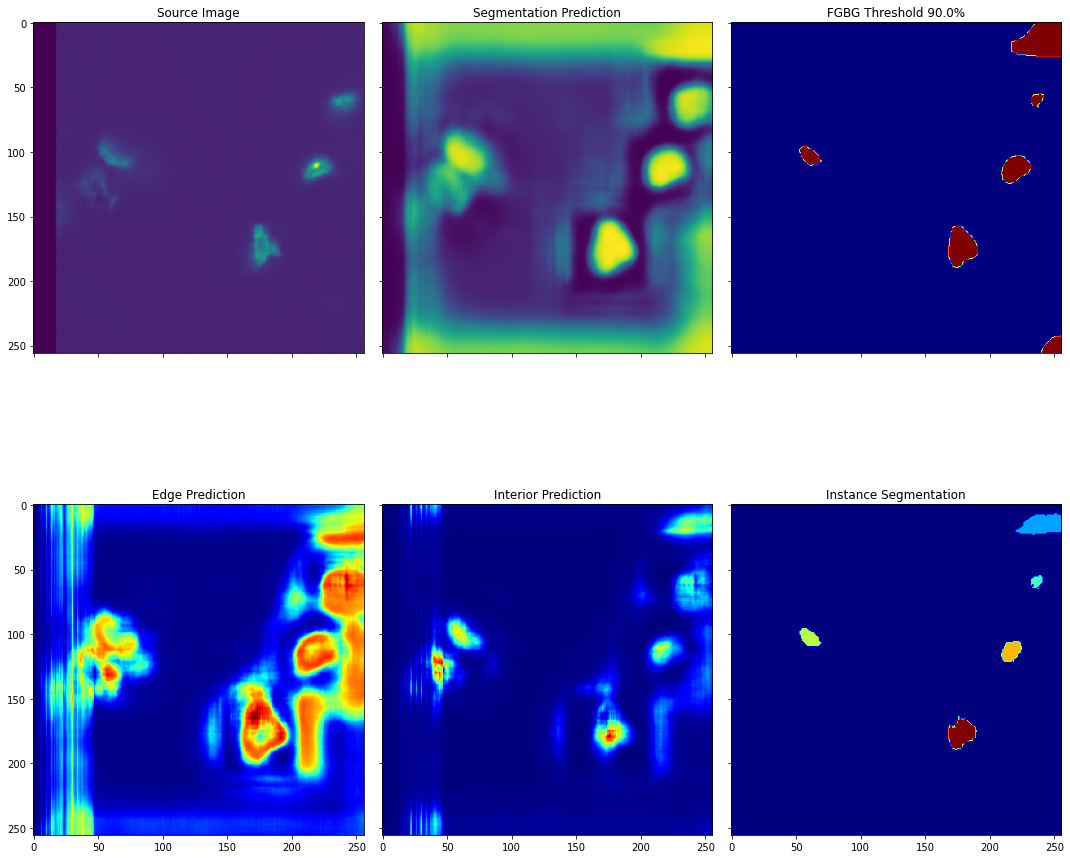

In [0]:
# Plot the results
import matplotlib.pyplot as plt

index = np.random.randint(low=0, high=labeled_images.shape[0])
frame = np.random.randint(low=0, high=labeled_images.shape[1])

print('Image:', index)
print('Frame:', frame)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, frame, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

ax[3].imshow(test_images[index, frame, ..., 0] + test_images[index, frame, ..., 1], cmap='jet')
ax[3].set_title('Edge Prediction')

ax[4].imshow(test_images[index, frame, ..., 2], cmap='jet')
ax[4].set_title('Interior Prediction')

ax[5].imshow(labeled_images[index, frame, ..., 0], cmap='jet')
ax[5].set_title('Instance Segmentation')
fig.tight_layout()
plt.show()

In [0]:
## Plot the results
import os
os.chdir('/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/deepcell-tf')
import matplotlib.pyplot as plt

PLOT_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'plots', PREFIX))
print(PLOT_DIR)
# create directories if they do not exist
try:
    os.makedirs(PLOT_DIR)
except OSError as exc:  # Guard against race condition
    if exc.errno != errno.EEXIST:
        raise

/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/3dsamplebased_seg/plots


In [0]:
A = np.concatenate((labeled_images, labeled_images), axis=0)

Image: 0
Frame: 1


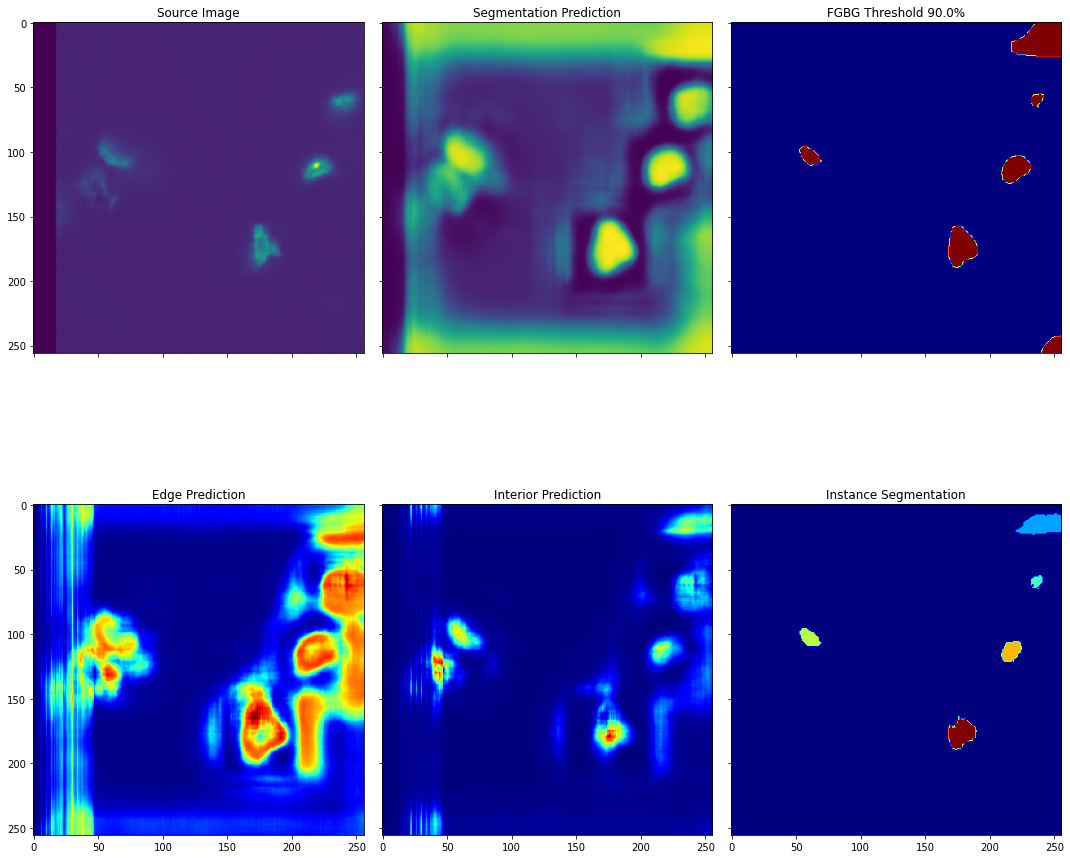

Image: 0
Frame: 6


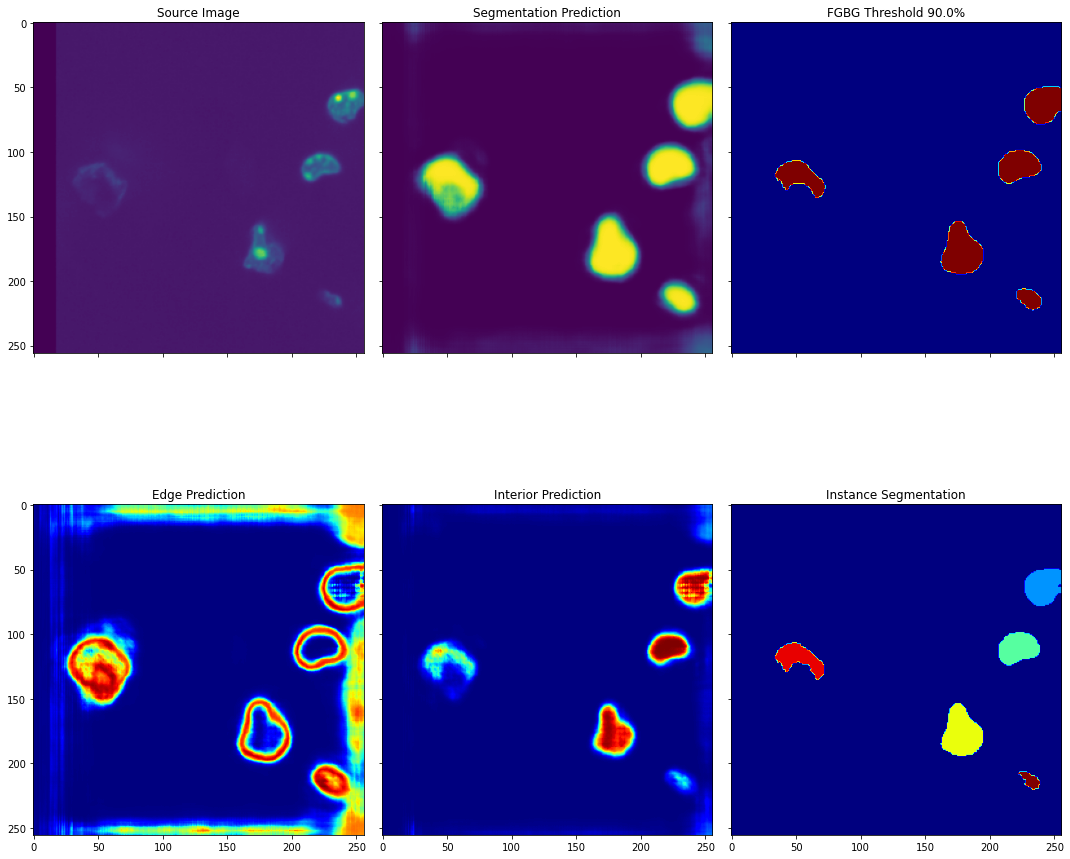

In [0]:
for i in range(A.shape[0]):
  index=0
  # index = np.random.randint(low=0, high=labeled_images.shape[0])
  frame = np.random.randint(low=0, high=labeled_images.shape[1])
  print('Image:', index)
  print('Frame:', frame)
  fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
  ax = axes.ravel()

  ax[0].imshow(X_test[index, frame, ..., 0])
  ax[0].set_title('Source Image')
  
  ax[1].imshow(test_images_fgbg[index, frame, ..., 1])
  ax[1].set_title('Segmentation Prediction')

  ax[2].imshow(fg_thresh[index, frame, ..., 0], cmap='jet')
  ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

  ax[3].imshow(test_images[index, frame, ..., 0] + test_images[index, frame, ..., 1], cmap='jet')
  ax[3].set_title('Edge Prediction')

  ax[4].imshow(test_images[index, frame, ..., 2], cmap='jet')
  ax[4].set_title('Interior Prediction')

  ax[5].imshow(labeled_images[index, frame, ..., 0], cmap='jet')
  ax[5].set_title('Instance Segmentation')

  fig.tight_layout()
  fig.savefig(os.path.join(PLOT_DIR, '{}.png'.format(np.str(i))), bbox_inches='tight')
  plt.show()
  

In [0]:
from deepcell.utils.plot_utils import get_js_video
from IPython.display import HTML

HTML(get_js_video(labeled_images, batch=0, channel=0))

Import model to tensorflow saved_model protobuffer

In [0]:
run_fgbg_model.input

<tf.Tensor 'input_1:0' shape=(?, 15, 256, 256, 1) dtype=float32>

In [0]:
run_fgbg_model.output

<tf.Tensor 'softmax/Softmax:0' shape=(?, 15, 256, 256, 2) dtype=float32>

In [0]:
import tensorflow as tf
import keras
from keras import backend as K
#If the model has only one input it can be converted
OUTPUT_DIR = os.path.join(MODEL_DIR, 'saved_model_fgbg') 

builder = tf.saved_model.builder.SavedModelBuilder(OUTPUT_DIR)

signature = tf.saved_model.signature_def_utils.predict_signature_def(
            inputs  = {'input':  run_fgbg_model.input},
            outputs = {'output': run_fgbg_model.output})
signature_def_map = { tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature }

builder.add_meta_graph_and_variables(K.get_session(), [tf.saved_model.tag_constants.SERVING],
                                             signature_def_map=signature_def_map)
builder.save()

#If the model has only one input it can be converted
OUTPUT_DIR = os.path.join(MODEL_DIR, 'saved_model_edgeseg') 

builder = tf.saved_model.builder.SavedModelBuilder(OUTPUT_DIR)

signature = tf.saved_model.signature_def_utils.predict_signature_def(
            inputs  = {'input':  run_watershed_model.input},
            outputs = {'output': run_watershed_model.output})
signature_def_map = { tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature }

builder.add_meta_graph_and_variables(K.get_session(), [tf.saved_model.tag_constants.SERVING],
                                             signature_def_map=signature_def_map)
builder.save()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.


Using TensorFlow backend.


INFO:tensorflow:SavedModel written to: /content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/3dsamplebased_seg/models/saved_model_fgbg/saved_model.pb
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/3dsamplebased_seg/models/saved_model_edgeseg/saved_model.pb


b'/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/3dsamplebased_seg/models/saved_model_edgeseg/saved_model.pb'

In [0]:
# Check if the folder has been properly created
import os
os.chdir(MODEL_DIR)
!ls -l

total 4514
-rw------- 1 root root 2306128 May  2 08:10 sample_edgeseg_3d_model.h5
-rw------- 1 root root     836 May  2 08:10 sample_edgeseg_3d_model.npz
-rw------- 1 root root 2304528 May  2 08:10 sample_fgbg_3d_model.h5
-rw------- 1 root root     836 May  2 02:56 sample_fgbg_3d_model.npz
drwx------ 3 root root    4096 May  4 10:29 saved_model_edgeseg
drwx------ 3 root root    4096 May  4 10:29 saved_model_fgbg


In [0]:
# Zip folder with the save model
from google.colab import files

!zip saved_model_edgeseg -r saved_model_edgeseg/
!zip saved_model_fgbg -r saved_model_fgbg/

# And download!
files.download("saved_model_fgbg.zip")
files.download("saved_model_edgeseg.zip")

  adding: saved_model_edgeseg/ (stored 0%)
  adding: saved_model_edgeseg/variables/ (stored 0%)
  adding: saved_model_edgeseg/variables/variables.data-00000-of-00001 (deflated 16%)
  adding: saved_model_edgeseg/variables/variables.index (deflated 60%)
  adding: saved_model_edgeseg/saved_model.pb (deflated 91%)
  adding: saved_model_fgbg/ (stored 0%)
  adding: saved_model_fgbg/variables/ (stored 0%)
  adding: saved_model_fgbg/variables/variables.data-00000-of-00001 (deflated 16%)
  adding: saved_model_fgbg/variables/variables.index (deflated 60%)
  adding: saved_model_fgbg/saved_model.pb (deflated 91%)
